# **Example Notebook on how to use an Autoencoder to study anomalies in NOAA time-series data**

*This notebook is built on colab, change the colab related cell as needed*

**Import the necessary libraries**


In [1]:
!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
from netCDF4 import Dataset
import numpy as np
import cftime
import requests
import os

**Mount the drive and define**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load the dataset build with the example notebook in this github repository (NOAA_DataDownload)**

In [10]:
NOAA_dataset_path = '/content/drive/MyDrive/TinyML/Anomalies/GOES-highenergy/2021/'

In [11]:
dir0 = NOAA_dataset_path
year= str(2021)
prefix = 'ops_seis-l1b-mpsh_g16_'
suffix = '_v0-0-0.nc'

**Dataset exploration**

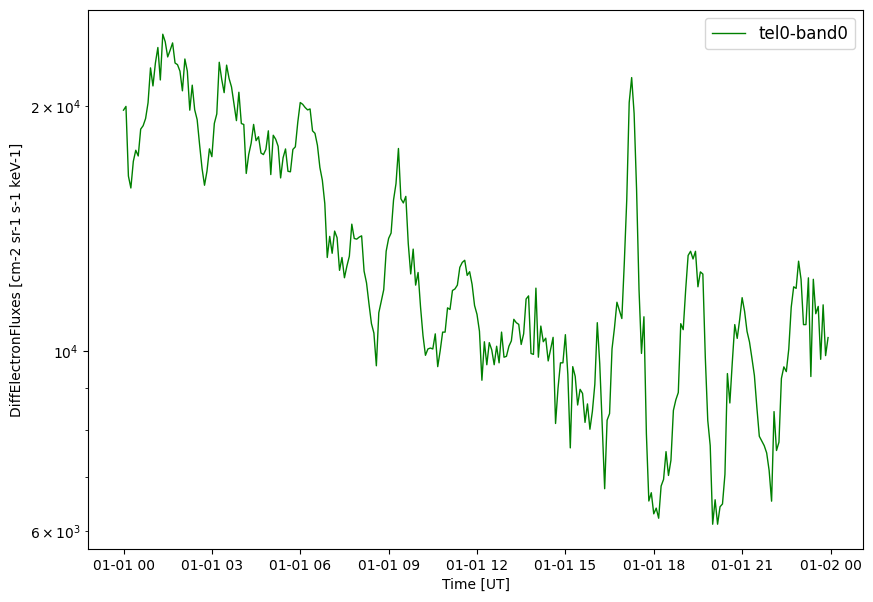

Done.



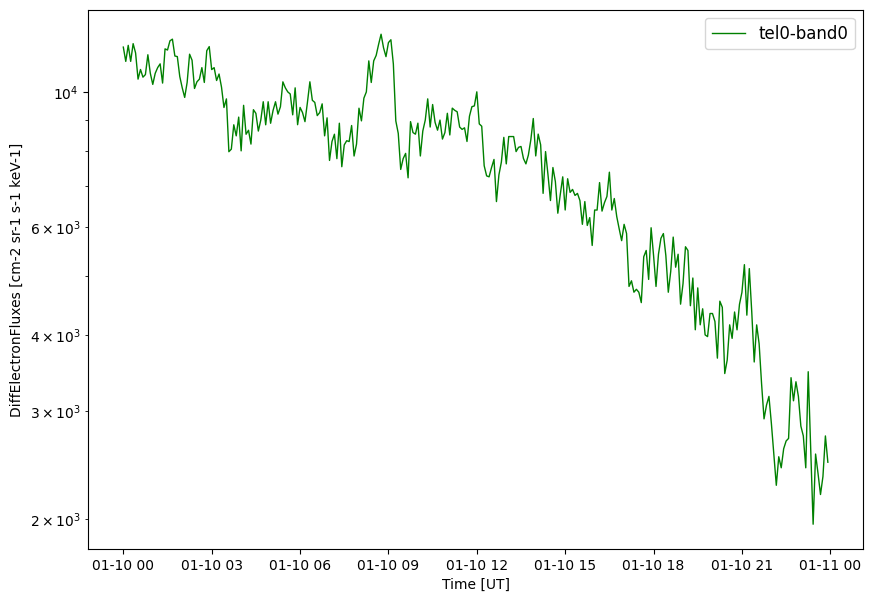

Done.



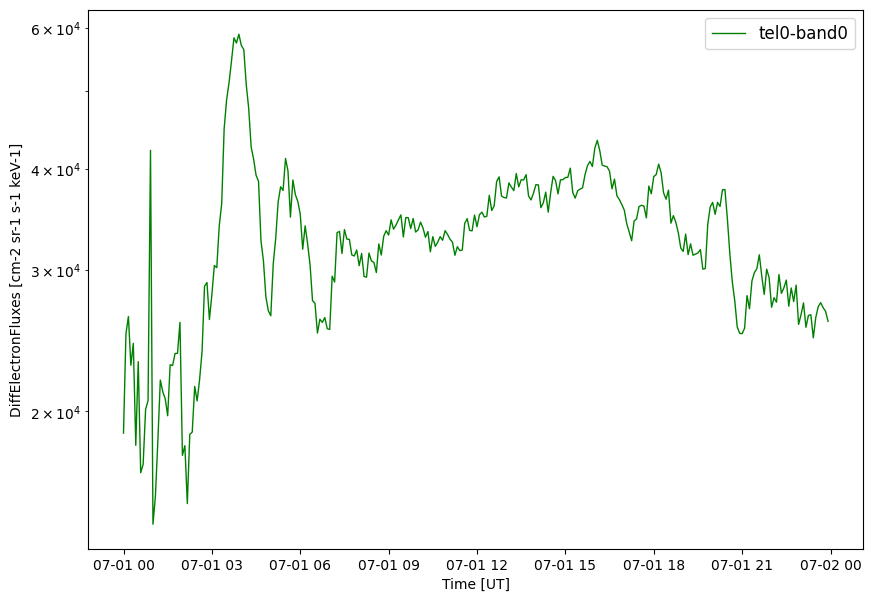

Done.



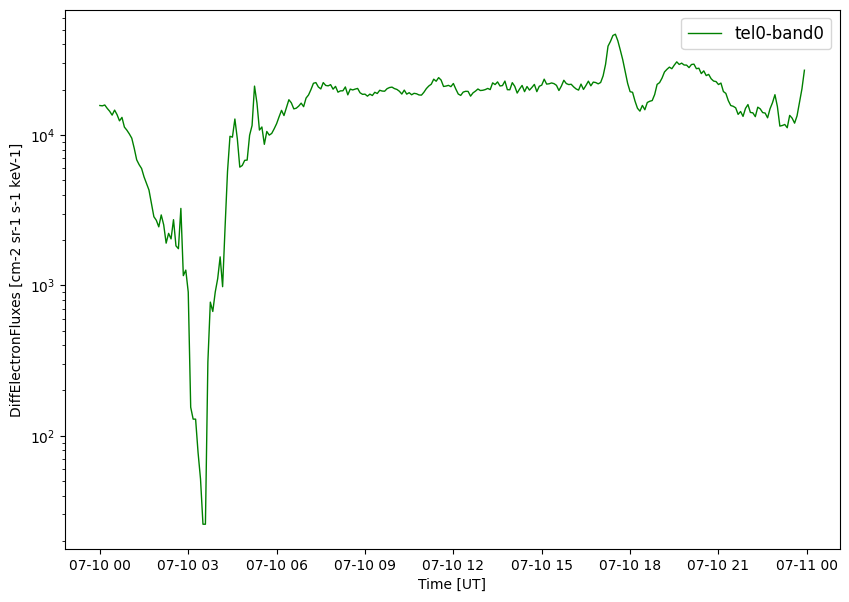

Done.



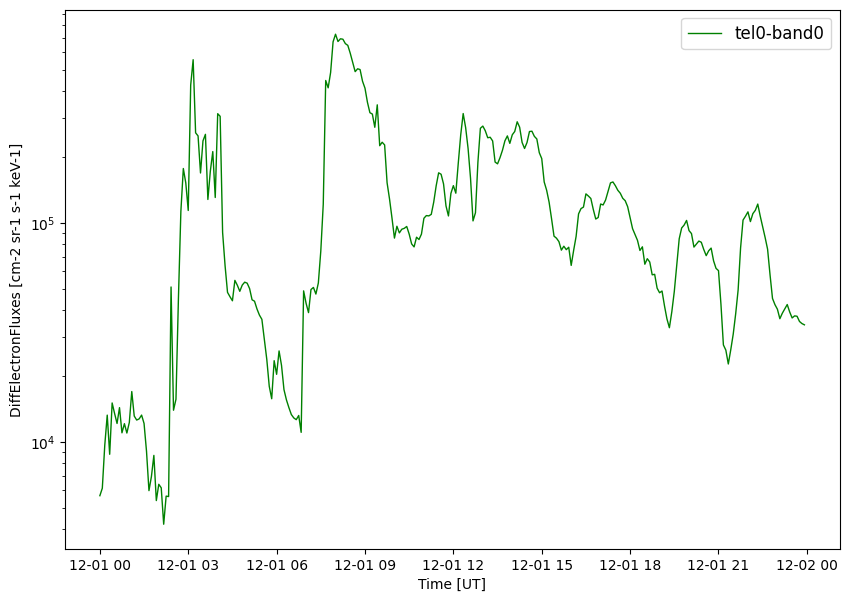

Done.



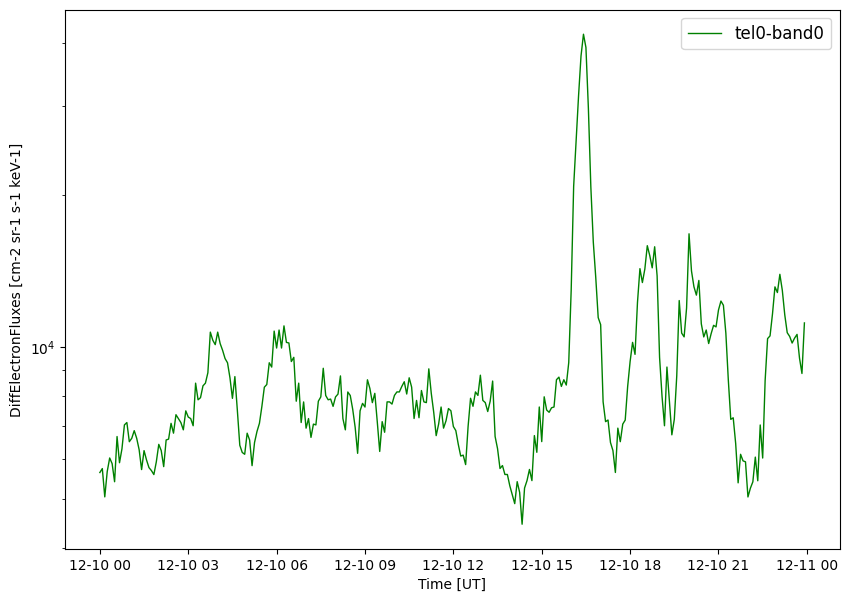

Done.



In [12]:


for month in (['01', '07',  '12']):
  for days in (['01', '10']):

    file_name = f'{prefix}d{year}{month}{days}{suffix}'
    ds = Dataset(dir0+file_name)
    times = cftime.num2pydate(ds.variables['L1a_SciData_TimeStamp'][:], ds['L1a_SciData_TimeStamp'].units)

    var = 'DiffElectronFluxes'
    tel = 0
    band = 0
    data = []
    for i in range(0, len(times), 300): #300 seconds interval
        data.append(ds.variables[var][i][tel][band])
    plt.figure(0, figsize=[10, 7])
    plt.plot(
        times[::300],
        data[:],
        linewidth=1,
        color='green',
        label=f'tel{tel}-band{band}',
    )
    plt.yscale('log')
    plt.legend(loc='upper right', prop={'size': 12})
    plt.xlabel('Time [UT]')
    plt.ylabel(f'{var} [{ds[var].units}]')
    plt.show()
    print('Done.\n')

# Function to define the mean e- flux in 30 seconds interval

In [14]:
def average_day(month, days, step_size=30):
    """
    Calculate the average e-flux in the day given and with the time interval defined
    Input:
    month (str)
    days (str)
    step_size(int)
    Return:
    mean e- flux in the given time interval
    """
    file_name = f'{prefix}d{year}{month}{days}{suffix}'
    ds = Dataset(dir0+file_name)
    times = cftime.num2pydate(ds.variables['L1a_SciData_TimeStamp'][:], ds['L1a_SciData_TimeStamp'].units)

    var = 'DiffElectronFluxes'
    tel = 0
    band = 0

    means = []

    # Iterate over the data in chunks
    for i in range(0, len(times), step_size):
        # Select the chunk of data
        chunk = ds.variables[var][i:i+ step_size][tel][band]
        # Compute mean and standard deviation for the chunk
        chunk_mean = np.mean(chunk)
        # Store the results
        means.append(chunk_mean)
    return means

We now consider the e- flux of days in 2021, with a 30 sec interval, to define the normal signal and a threshold for anomalies to build the training set for the autoencoder

In [15]:
means_year =  []

In [16]:
for month in (['01', '02','03', '04', '05', '06', '07', '08', '09', '10', '11', '12']):
  for days in (['01', '02','03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']):
    means_year.append(average_day(month, days))

In [25]:
means_year = np.array(means_year)

<ipython-input-25-cd38f8b06fc0>:1: UserWarning: Warning: converting a masked element to nan.
  means_year = np.array(means_year)


Text(0, 0.5, 'DiffElectronFluxes [cm-2 sr-1 s-1 keV-1]')

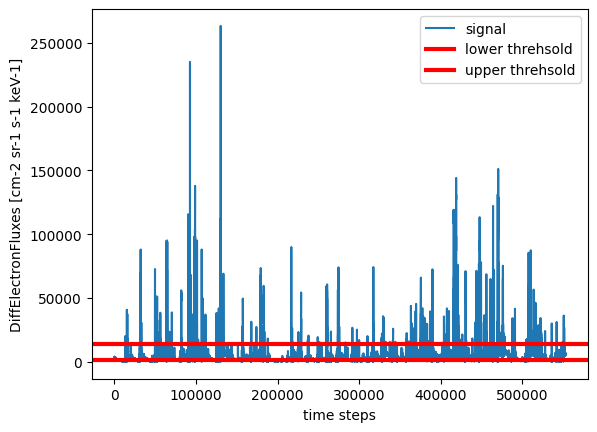

In [26]:
plt.plot(np.array(means_year).flatten(), label="signal")
plt.axhline(np.array(np.nanquantile(means_year.flatten(), 0.15)), linestyle='-', color='red', linewidth=3, label="lower threhsold")
plt.axhline(np.array(np.nanquantile(means_year.flatten(), 0.95)), linestyle='-', color='red', linewidth=3, label="upper threhsold")
plt.legend()
plt.xlabel('time steps')
plt.ylabel(f'{var} [{ds[var].units}]')

In [27]:
quantile_15 = np.nanquantile(means_year.flatten(), 0.15)
quantile_95 = np.nanquantile(means_year.flatten(), 0.95)


# Defyining anomaly and normal data

In [28]:
def anomaly_dates(month, days, step_size = 30):

    """
    Calculate the average signal in 30 seconds interval for the days given and
    looks for anomalies (signal below or higher than thresholds)
    Input:
    month (str)
    days (str)
    step_size(int)
    Return:
    days when anomalies are detected
    """

    file_name = f'{prefix}d{year}{month}{days}{suffix}'
    ds = Dataset(dir0+file_name)
    times = cftime.num2pydate(ds.variables['L1a_SciData_TimeStamp'][:], ds['L1a_SciData_TimeStamp'].units)

    var = 'DiffElectronFluxes'
    tel = 0
    band = 0



    anomaly_dates = []

    # Iterate over the data in chunks
    for i in range(0, len(times), step_size):
        # Select the chunk of data
        chunk = ds.variables[var][i:i+ step_size][tel][band]
        # Compute mean and standard deviation for the chunk
        chunk_mean = np.mean(chunk)
        if chunk_mean>quantile_95:
        # Store the results
          anomaly_dates.append(month+days)
          break
    return anomaly_dates

In [29]:
dates_with_anom = []

In [30]:
months = ["{:02}".format(i) for i in range(1, 13)]
days = ["{:02}".format(i) for i in range(1, 17)]
dates = [[month, day] for month, day in itertools.product(months, days)]

for i, j in dates:
  dates_with_anom.append(anomaly_dates(i, j))

In [31]:
month_anom = []
day_anom = []

In [32]:
for i in range(len(dates_with_anom)):
  if len(dates_with_anom[i])>0:
    month_anom.append(dates_with_anom[i][0][0:2])
    day_anom.append(dates_with_anom[i][0][2:4])


# construct the anomaly dataset
Here we have the average e- flux ina  30 sec interval for days where anomaly are detected

In [33]:
anom_data = []

In [34]:

for month, days in zip(month_anom, day_anom):
      anom_data.append(average_day(month, days))


<ipython-input-35-5844ff5cfd8b>:1: UserWarning: Warning: converting a masked element to nan.
  plt.plot(np.array(anom_data).flatten(), color='red', label = "days with anomaly")


Text(0, 0.5, 'DiffElectronFluxes [cm-2 sr-1 s-1 keV-1]')

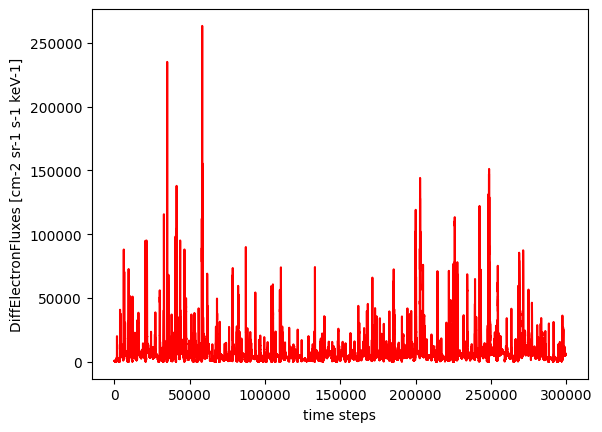

In [35]:
plt.plot(np.array(anom_data).flatten(), color='red', label = "days with anomaly")
plt.xlabel('time steps')
plt.ylabel(f'{var} [{ds[var].units}]')

# Build normal dataset

Here we have the average e- flux ina  30 sec interval for days where anomaly are NOT detected

In [98]:
anom_dates_array = combined_array = [[a, b] for a, b in zip(month_anom, day_anom)]

In [158]:
import itertools

# Arrays for months and days
months = ["{:02}".format(i) for i in range(1, 13)]
days = ["{:02}".format(i) for i in range(1, 17)]


# Generate all possible combinations of months and days
all_combinations = [[month, day] for month, day in itertools.product(months, days)]

# Filter out the dates that need to be removed to build the normal days set
normal_dates = [date for date in all_combinations if date not in anom_dates_array]



In [159]:
baseline_data = []


In [160]:
for i, j in normal_dates:
  baseline_data.append(average_day(i, j, step_size=30))


<ipython-input-161-e2084c6aac54>:1: UserWarning: Warning: converting a masked element to nan.
  plt.plot(np.array(baseline_data).flatten(), color='black')


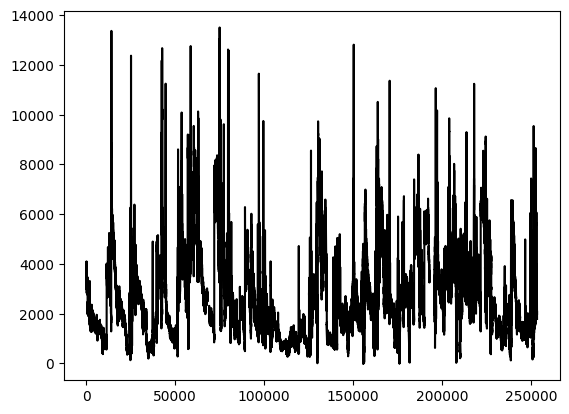

In [161]:
plt.plot(np.array(baseline_data).flatten(), color='black')


# Dataset for the autoencoder

In [162]:
baseline_data = np.array(baseline_data).flatten()
anom_data = np.array(anom_data).flatten()

<ipython-input-162-eda528fafe43>:1: UserWarning: Warning: converting a masked element to nan.
  baseline_data = np.array(baseline_data).flatten()


In [103]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [163]:
time_series_data = np.concatenate([baseline_data, anom_data])

# Reshape data for scaling
time_series_data = time_series_data[~np.isnan(time_series_data)].reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
time_series_data_scaled = scaler.fit_transform(time_series_data)

In [164]:
input_dim = time_series_data_scaled.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

In [165]:
# Using only the first half of the data (which is normal) for training
train_data = time_series_data_scaled[:50000]

history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          batch_size=32,
                          validation_split=0.1,
                          shuffle=True)

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1009 - val_loss: 0.0014
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8572e-04 - val_loss: 2.2398e-04
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1813e-04 - val_loss: 6.8752e-05
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7967e-05 - val_loss: 2.9260e-05
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.7229e-05 - val_loss: 1.7913e-05
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.5502e-05 - val_loss: 1.5804e-05
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.4607e-05 - val_loss: 1.6178e-05
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3678e-05 - val_loss: 1.4955e-05
Epoch 9/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3676e-05 - val_loss: 1.4348e-05
Epoch 10/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.0977e-05 - val_loss: 1.5763e-05
Epoch 11/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 2

In [166]:
test_set = np.concatenate([time_series_data_scaled])

In [167]:
# Reconstruct the data
reconstructed_data = autoencoder.predict(test_set)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(np.power(test_set - reconstructed_data, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # 95th percentile

# Detect anomalies
anomalies = mse > threshold



17117/17117 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


In [168]:
times = np.linspace(0, len(test_set), len(test_set))

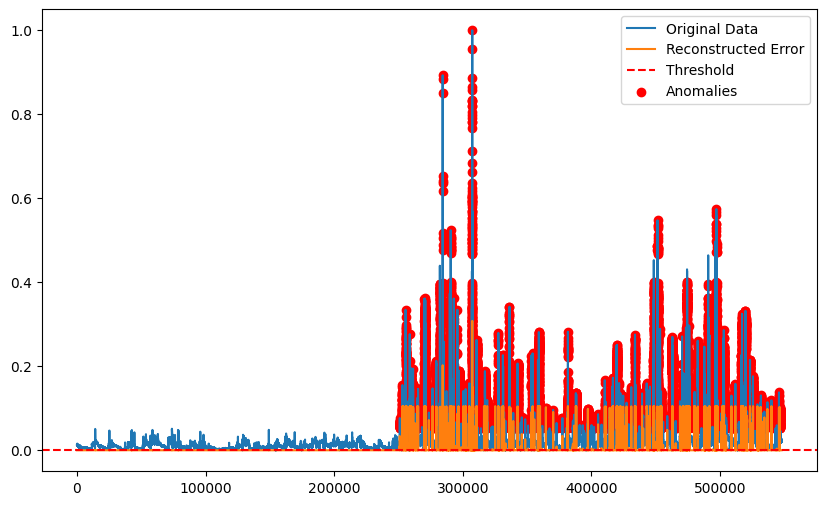

In [169]:
# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(times, test_set, label="Original Data")
plt.plot(times, mse, label="Reconstructed Error")
plt.axhline(y=threshold, color="r", linestyle="--", label="Threshold")
plt.scatter(times[anomalies], test_set[anomalies], color='red', label="Anomalies")
plt.legend()
plt.show()